In [191]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, assemble
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.primitives import Sampler
import matplotlib.pyplot as plt
qc = QuantumCircuit()

In [ ]:
# Apply the layout to the observables
layout = [0, 1, 2]  # Assuming 3 qubits
mapped_observables = [observable.apply_layout(layout) for observable in observables]
observables_labels = ["III", "ZZZ", "XXX", "ZXX", "XXZ", "XZZ"]
observables = [SparsePauliOp(label) for label in observables_labels]

In [193]:
qc = QuantumCircuit(3,2)
qc.initialize([0.6, 0.8], 0)
qc.barrier()
qc.draw()
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure([0, 1], [0, 1])
qc.barrier()
qc.cx(1, 2)
qc.cz(0, 2)
qc.measure([2], [1])
qc.draw()


┌─────────────────────┐ ░            ░      ┌───┐ ░ ┌─┐    ░            
q_0: ┤ Initialize(0.6,0.8) ├─░────────────░───■──┤ H ├─░─┤M├────░───────■────
     └─────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░       │    
q_1: ────────────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───■───┼────
                             ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░ ┌─┴─┐ │ ┌─┐
q_2: ────────────────────────░──────┤ X ├─░────────────░──╫──╫──░─┤ X ├─■─┤M├
                             ░      └───┘ ░            ░  ║  ║  ░ └───┘   └╥┘
c: 2/═════════════════════════════════════════════════════╩══╩═════════════╩═
                                                          0  1             1

This is the Quantum Circuit as discussed in the meet to teleport a qubit from A to B

In [ ]:
# Set up the simulator backend
aer_sim = Aer.get_backend('aer_simulator')
qobj = transpile(qc)
job = aer_sim.run(qobj, shots=1000)
hist = job.result().get_counts()
# Calculate probabilities by normalizing the counts
total_shots = sum(hist.values())
probabilities = {key: value / total_shots for key, value in hist.items()}
# Print the histogram and the probabilities
print("Probabilities:", probabilities)

Probabilities: {'10': 0.332, '01': 0.163, '11': 0.317, '00': 0.188}


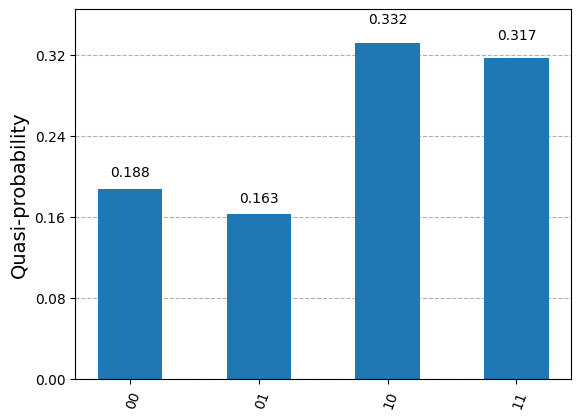

In [195]:
plot_histogram(probabilities)


The probabilities closely match the expected values derived from the state 0.6∣0⟩+0.8∣1⟩ If you actually draw and derive the bell states, where squaring the amplitudes gives ∣0⟩ ≈ 0.36 and ∣1⟩ ≈ 0.64. Some variations are seen 

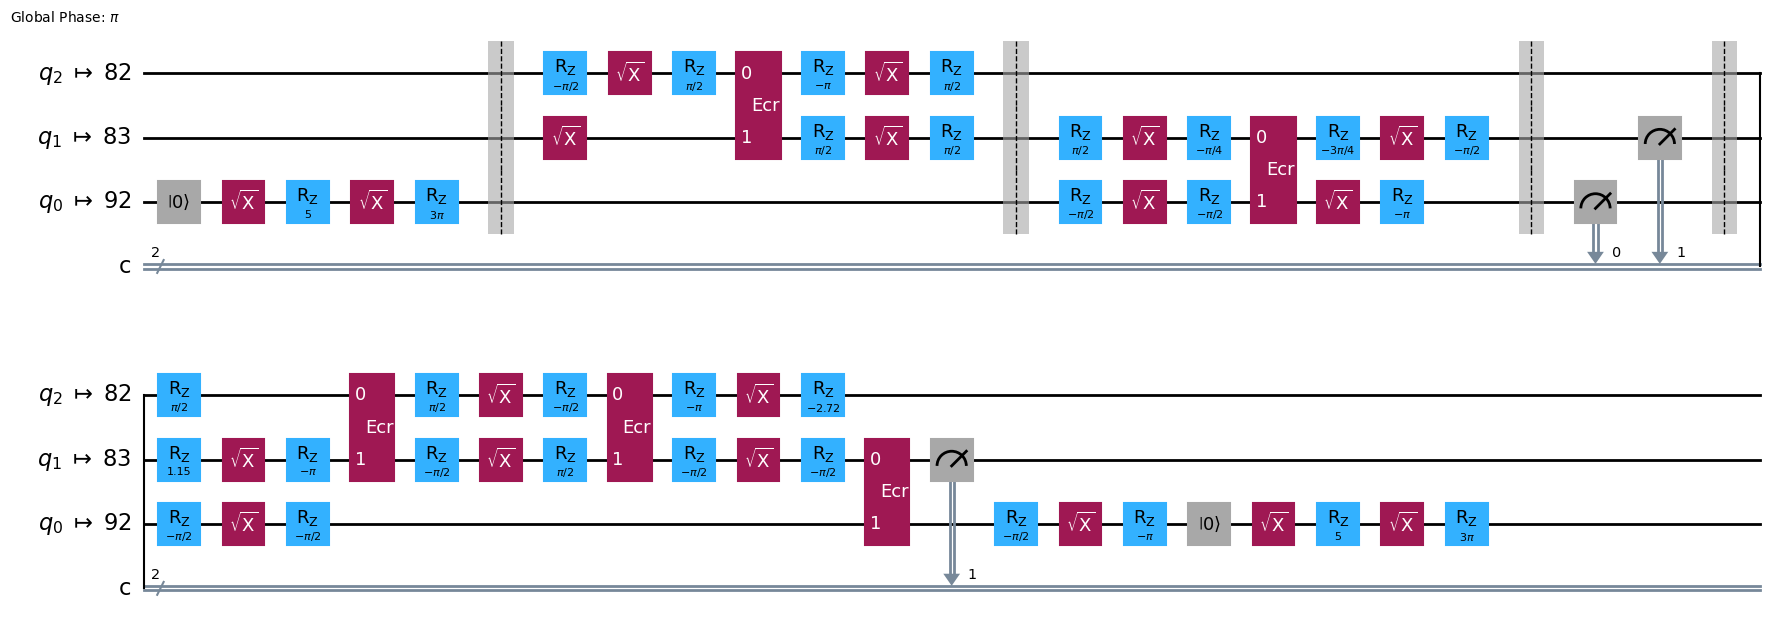

In [196]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

qc.initialize([0.6, 0.8], 0)

service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)

isa_circuit = transpile(qc, backend=backend, optimization_level=3)

isa_circuit.draw("mpl", idle_wires=False)


initializes a quantum circuit with a state 0.6∣0⟩+0.8∣1⟩, transpiles it for the least busy IBM quantum backend with optimization level 3, and visualizes the optimized circuit while omitting idle wires.

In [197]:
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 10000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])

print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cxevszq3ej4g008fyqag


Uses the Estimator to compute expectation values of observables for the optimized quantum circuit on the chosen backend, while mapping observables to the transpiled circuit's layout.

In [198]:
job_result = job.result()
pub_result = job.result()[0]

In [199]:
quasi_dists = Sampler().run(isa_circuit, shots=1000).result().quasi_dists[0]

# Mapping the numbers 0, 1, 2, 3 to binary strings '00', '01', '10', '11'
formatted_quasi_dists = {format(k, '02b'): v for k, v in quasi_dists.items()}

print(formatted_quasi_dists)

{'10': 0.327, '11': 0.326, '00': 0.171, '01': 0.176}


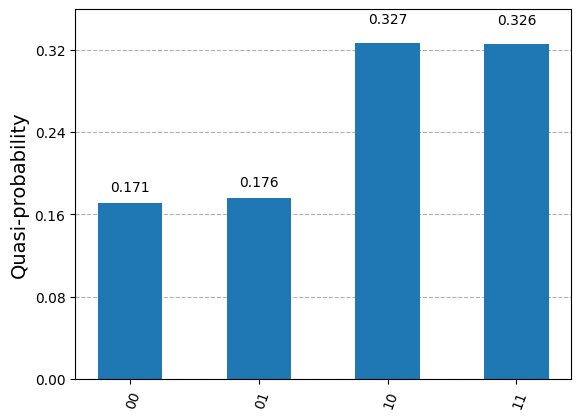

In [200]:
plot_histogram(formatted_quasi_dists)

Both results exhibit a similar trend where the states 10 and 11 have higher probabilities than 00 and 01. This suggests that the quantum circuit behaves as expected, and the general outcome probabilities align well.


Noise in Real Hardware: IBM hardware results show slight variations (e.g., 01 higher than 00) due to noise from decoherence, gate errors, and readout errors, which cause small deviations from ideal probabilities.